__BIOBSS - Activity Indices__

_This notebook includes guidelines to help using BIOBSS for calculation of activity indices and feature extraction from ACC signal._

In [1]:
#Import BIOBSS and the other required packages

import biobss
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [ACC Sample Data](#sampledata)<br>
2. [ACC Signal Preprocessing](#acc_pre)<br>
    2.1. [Filtering](#acc_filter)<br>
    2.2. [Peak Detection](#acc_peaks)<br>
3. [Activity indices from ACC signals](#acc_actind)<br>
    3.1. [Dataset Generation](#acc_dataset)<br>
    3.2. [Calculation of Activity Indices](#act_ind)<br>
4. [ACC Feature Extraction](#acc_features)<br>

### __ACC Sample Data__
<a id="sampledata"></a>

ACC sample data is provided as a csv file in BIOBSS\sample data. The data file contains 3-axis ACC signals of 5-minutes length, sampled at 32 Hz. 

In [2]:
#Load the sample data. The sample data file contains 100 10-s PPG segments. The samling rate of the segments is 64 Hz. 

data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"sample_data")
filename='acc_sample_data.csv'
data=pd.read_csv(os.path.join(data_dir,filename), header=None)

#Select the first 60s segment to be used in the examples
fs=32
L=60
accx=np.asarray(data.iloc[:fs*L,0]) #x-axis acceleration signal
accy=np.asarray(data.iloc[:fs*L,1]) #y-axis acceleration signal
accz=np.asarray(data.iloc[:fs*L,2]) #z-axis acceleration signal


### __ACC Signal Preprocessing__
<a id="acc_pre"></a>

#### __Filtering__
<a id="acc_filter"></a>

BIOBSS library provides a filtering function which uses Scipy functions. This function can be used to implement Butterworth filter by defining the filter parameters (filter type, filter order, cutoff frequencies) as shown below.

In [3]:
#Filtering ACC signals by defining the filter parameters

f_accx= biobss.preprocess.filter_signal(accx,fs,'lowpass',N=2,f_upper=10)
f_accy= biobss.preprocess.filter_signal(accy,fs,'lowpass',N=2,f_upper=10)
f_accz= biobss.preprocess.filter_signal(accz,fs,'lowpass',N=2,f_upper=10)

As an alternative, pre-defined filters can be used for each signal type. In order to use this option, signal_type should be selected as 'ACC'. 

In [ ]:
#Filter ACC signal by using predefined filters
filtered_accx=biobss.preprocess.filter_signal(accx, fs, signal_type='ACC')
filtered_accy=biobss.preprocess.filter_signal(accy, fs, signal_type='ACC')
filtered_accz=biobss.preprocess.filter_signal(accz, fs, signal_type='ACC')

#### __Peak Detection__
<a id="acc_peaks"></a>

BIOBSS provides a peak detection function with different alternatives for the peak detection method. The ___peak_detection___ function returns a dictionary including peak locations, peak amplitudes, trough locations and trough amplitudes.

In [4]:
#Detect peaks using 'peakdet' method (delta=0.01). 
#Delta parameter should be adjusted related to the amplitude of the signal.

info=biobss.preprocess.peak_detection(accx,fs,'peakdet',delta=0.01)

locs_peaks=info['Peak_locs']
peaks=info['Peaks']
locs_onsets=info['Trough_locs']
onsets=info['Troughs']

BIOBSS provides plotting functions specific to each signal type. In order to plot ACC signals, ___plot_acc___ function can be used. The signals and peaks should be provided as dictionaries, and the keys should be selected as in documentation. The plots can be generated either using __Matplotlib__ or __Plotly__. 

In [ ]:
#Generate inputs as dictionaries
signals = {'x-axis':{'Raw': accx , 'Filtered': f_accx}, 'y-axis':{'Raw': accy , 'Filtered': f_accy}, 'z-axis':{'Raw': accz , 'Filtered': f_accz}}
peaks = {'x-axis':{'Peaks': {'Location':locs_peaks, 'Amplitude':accx[locs_peaks]}}, 'y-axis':{'Peaks':{'Location':locs_peaks, 'Amplitude':accy[locs_peaks]}}, 'z-axis':{'Peaks':{'Location':locs_peaks, 'Amplitude':accz[locs_peaks]}}}

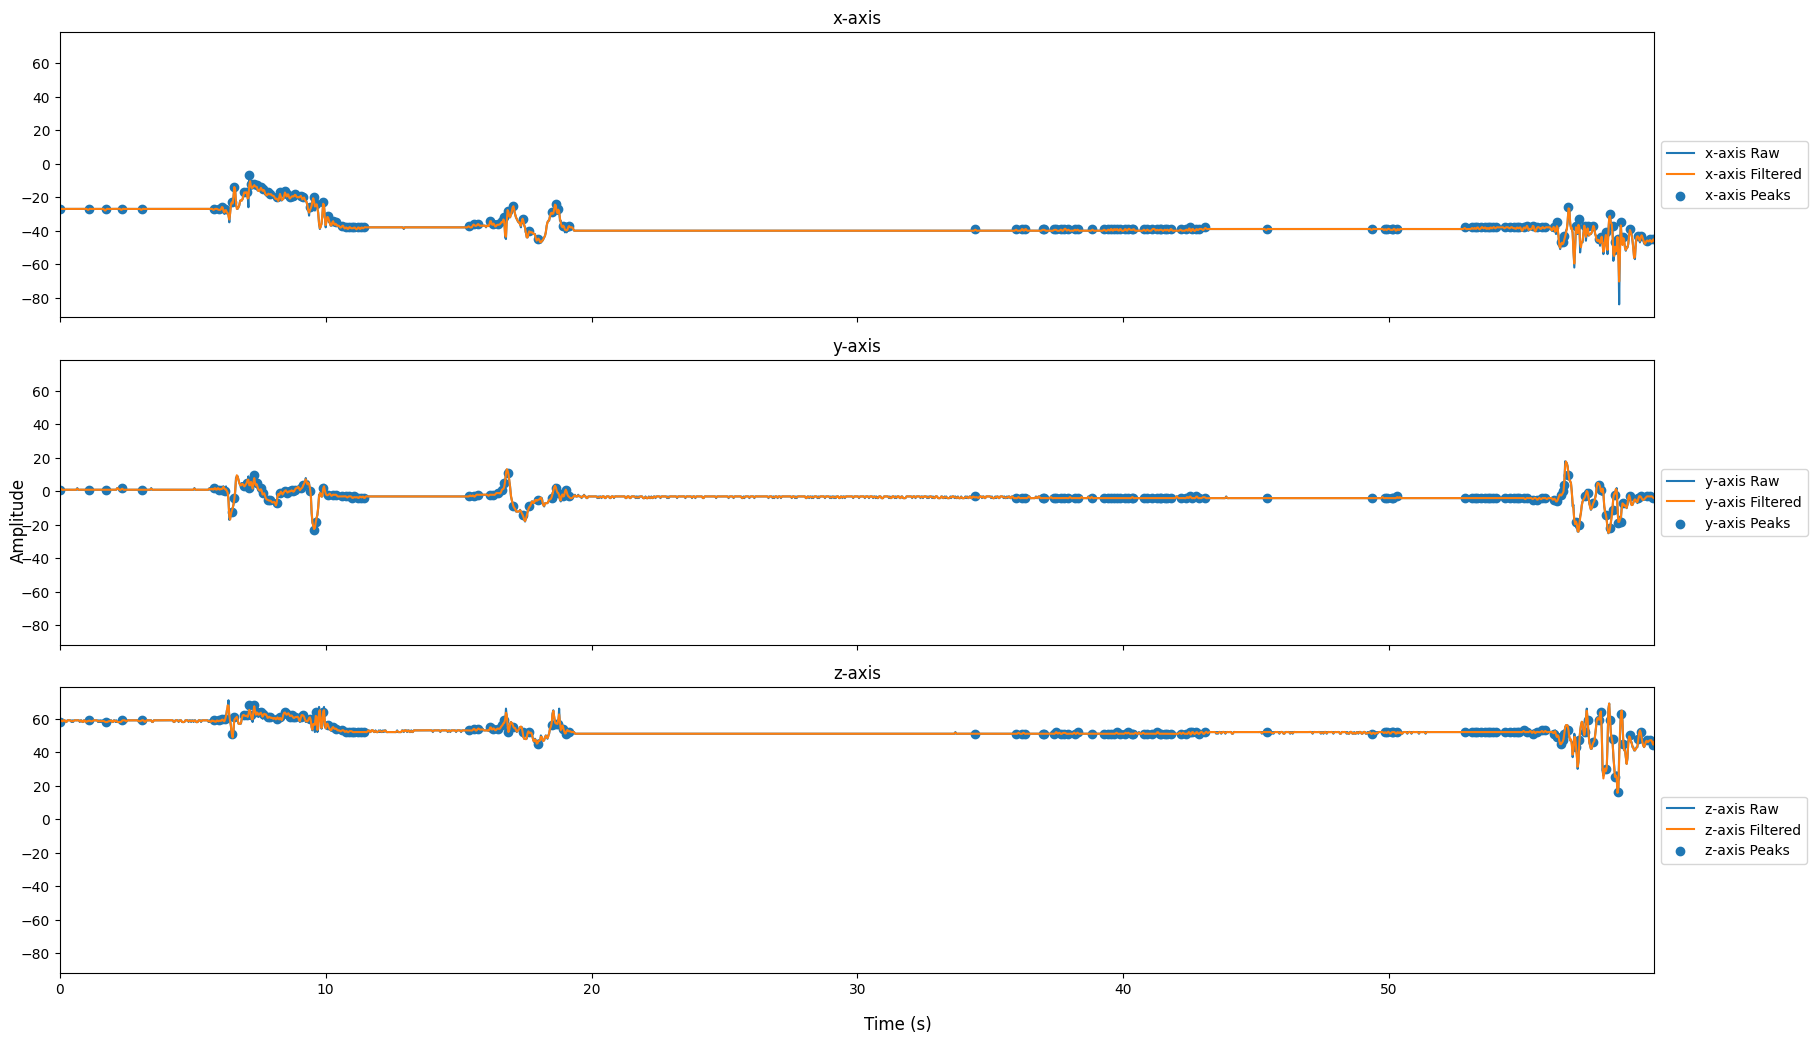

In [5]:
#Plot ACC signals using Matplotlib
biobss.imutools.plot_acc(signals=signals, peaks=peaks, sampling_rate=fs, show_peaks=True)

In [6]:
#Plot ACC signals using Plotly
biobss.imutools.plot_acc(signals=signals, peaks=peaks, sampling_rate=fs, method='plotly', show_peaks=True)

### __Activity Indices from ACC Signals__
<a id="acc_actind"></a>

BIOBSS provides a set of functions to calculate activity indices defined in the literature. These activity indices are:

- Proportional Integration Method (PIM)
- Zero Crossing Method (ZCM)
- Time Above Threshold (TAT)
- Mean Amplitude Deviation (MAD)
- Euclidian Norm Minus One (ENMO)
- High-pass Filtered Euclidian (HFEN)
- Activity Index (AI)

Reference: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0261718


#### __Dataset Generation__
<a id="acc_dataset"></a>

The activity indices listed above requires different types of preprocessing steps of the raw acceleration signal. In other words, each activity index can be calculated using only specific datasets. BIOBSS package provides the ___generate_dataset___ function to apply appropriate preprocessing steps (dataset generation) to prevent errors and make the process easier for the researchers.

The generated datasets are:
- UFXYZ: unfiltered acc signals 
- UFM: magnitude of unfiltered acc signals 
- UFM_modified: modified magnitude of unfiltered signals (absolute(UFM-length(UFM)))
- UFNM: normalized magnitude of unfiltered acc signals 
- FXYZ: filtered acc signals
- FXYZ_modified: modified filtered acc signals (absolute(FXYZ))   
- FMpre: magnitude of filtered acc signals
- SpecialXYZ: filtered acc signals (special filter parameters)  
- SpecialM: magnitude of filtered acc signals (special filter parameters)
- FMpost: filtered magnitude of acc signals
- FMpost_modified: modified of filtered magnitude of acc signals (absolute(FMpost))


Dataset generation step is a part of activity index calculation pipeline and the ___generate_dataset___ function is called by the ___calc_activity_index___ function. However, this function can also be used independently by defining input arguments properly as shown below.

In [ ]:
#Generate the datasets
ufxyz           = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=False,filtering_order=None,magnitude=False,normalize=False,modify=False),
ufm             = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=False,filtering_order=None,magnitude=True,normalize=False,modify=False),
ufm_modified    = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=False,filtering_order=None,magnitude=True,normalize=False,modify=True),
ufnm            = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=False,filtering_order=None,magnitude=True,normalize=True,modify=False),
fxyz            = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='pre',magnitude=False,normalize=False,modify=False),
fxyz_modified   = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='pre',magnitude=False,normalize=False,modify=True),
fmpre           = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='pre',magnitude=True,normalize=False,modify=False),
specialxyz      = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='pre',magnitude=False,normalize=False,modify=False,filter_type='highpass',N=4,f_lower=0.2),
specialm        = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='pre',magnitude=True,normalize=False,modify=False,filter_type='highpass',N=4,f_lower=0.2),
fmpost          = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='post',magnitude=True,normalize=False,modify=False),
fmpost_modified = biobss.imutools.generate_dataset(accx,accy,accz,fs,filtering=True,filtering_order='post',magnitude=True,normalize=False,modify=True)
                    

#### __Calculation of Activity Indices__
<a id="act_ind"></a>

The ___calc_activity_index___ function is used to calculate an activity index defined by 'metric' for the selected 'input_types'. Note that if the 'input_types' is not passed to the function, the activity metric is calculated for all of the valid input types.  

In [ ]:
#Calculate activity indices
pim = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='PIM')
zcm = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='ZCM')
tat = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='TAT')
mad = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='MAD')
enmo = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='ENMO')
hfen = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='HFEN')
ai = biobss.imutools.calc_activity_index(accx, accy, accz, signal_length=60, sampling_rate=fs, metric='AI', baseline_variance=[0.5,0.5,0.5])

### __ACC Feature Extraction__
<a id="acc_features"></a>

In the literature, there are several features used for analysis of ACC signals. These features can be categorized as frequency domain features, statistical features and correlation features. 

Statistical features:
- 'mean': mean of the signal amplitude
- 'std': standard deviation of the signal amplitude
- 'mad': mean absolute deviation of the signal amplitude
- 'min': minimum value of the signal amplitude
- 'max': maximum value of the signal amplitude
- 'range': difference of maximum and minimum values of the signal amplitude
- 'median': median value of the signal amplitude
- 'medad': median absolute deviation of the signal amplitude
- 'iqr': interquartile range of the signal amplitude
- 'ncount': number of negative values 
- 'pcount': number of positibe values 
- 'abmean': number of values above mean
- 'npeaks': number of peaks
- 'skew': skewness
- 'kurtosis': kurtosis
- 'energy': signal energy (the mean of sum of squares of the values in a window)
- 'momentum': momentum

Frequency domain features:
- 'fft_mean': mean of fft peaks
- 'fft_std': standard deviation of fft peaks
- 'fft_mad': mean absolute deviation of fft peaks
- 'fft_min': minimum value of fft peaks
- 'fft_max': maximum value of fft peaks
- 'fft_range': difference of maximum and minimum values of fft peaks
- 'fft_median': median value of fft peaks
- 'fft_medad': median absolute deviation of fft peaks
- 'fft_iqr': interquartile range of fft peaks
- 'fft_abmean': number of fft peaks above mean
- 'fft_npeaks': number of fft peaks
- 'fft_skew': skewness of fft peaks
- 'fft_kurtosis': kurtosis of fft peaks
- 'fft_energy': energy of fft peaks
- 'fft_entropy': entropy of fft peaks
- 'f1sc': signal power in the range of 0.1 to 0.2 Hz
- 'f2sc': signal power in the range of 0.2 to 0.3 Hz
- 'f3sc': signal power in the range of 0.3 to 0.4 Hz
- 'max_freq': frequency of maximum fft peak

Correlation features:
- 'accx_accy_corr': correlation coefficient for x and y axes
- 'accx_accz_corr': correlation coefficient for x and z axes
- 'accy_accz_corr': correlation coefficient for y and z axes

Reference: https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60

These features can be calculated seperately for each domain using the functions ___get_freq_features___, ___get_stat_features___ and ___get_corr_features___. Note that ___get_freq_features___ and ___get_stat_features___  functions calculate the features for one signal at a time.

In [ ]:
#Calculate frequency domain and statistical features for x-axis acceleration signal
accx_freq = biobss.imutools.acc_features.get_freq_features(accx, sampling_rate=fs, prefix='accx')
accx_stat = biobss.imutools.acc_features.get_stat_features(accx, sampling_rate=fs, prefix='accx')

In [ ]:
#Calculate correlation features
signals = {}
signals['accx'] =accx
signals['accy'] =accy
signals['accz'] =accz

accx_corr = biobss.imutools.acc_features.get_corr_features(signals, prefix='accx')

The ___get_acc_features___ function is used to calculate features for multiple domains at a time. ACC signals should be provided as a dictionary with the keys 'accx', 'accy' and 'accz'. In order to calculate the features for the magnitude signal, 'magn' should be True.

In [ ]:
features_acc = biobss.imutools.get_acc_features(signals, sampling_rate=fs, magnitude=True)